In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from germansentiment import SentimentModel
import re
from tqdm.notebook import tqdm
import numpy as np
# surpress warnings
import warnings
warnings.filterwarnings('ignore')

# Sentiment in the #BTW17 Dataset
After having a good intuition about the different topics in this dataset, we will now analyze the sentiment in the tweets. Here, we will focus on the tweets of the politicians only.

For the sentiment analysis, we will use this classifier: https://huggingface.co/oliverguhr/german-sentiment-bert.

## Sentiment analysis in general

To get an intuition of the general sentiment given the politicians tweets, we plotted the sentiment over time

In [ ]:
"""
model = SentimentModel()
tweets = pd.read_json('../data/politician_tweets.json')

# construct docs
docs = tweets['text'].tolist()
for i in range(len(docs)):
    # remove mentions
    docs[i] = re.sub('@[A-Za-z0-9_]+', '', docs[i])
    # remove hashtags
    docs[i] = re.sub('#[A-Za-z0-9_]+', '', docs[i])
    # remove links
    docs[i] = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)', '', docs[i])
    # strip whitespaces
    docs[i] = [docs[i].strip()]
sentiments = []

# get sentiment per tweet
for i in tqdm(range(len(docs))):
    sentiments.append(model.predict_sentiment(docs[i]))

# save labels in dataframe
tweets['sentiment'] = np.squeeze(sentiments)

# score
tweets['sen_score'] = np.where(tweets['sentiment']=='positive', 1.0, np.where(tweets['sentiment']=='negative', -1.0, 0.0))
tweets.to_json('../data/politician_tweets_sentiment.json')
"""

In [4]:
tweets = pd.read_json('../data/politician_tweets_sentiment.json')
tweets['date'] = tweets['date'].dt.strftime('%Y-%m-%d')

In [5]:
# https://stackoverflow.com/questions/62710057/access-color-from-plotly-color-scale

import plotly.colors

def get_continuous_color(colorscale, intermed):
    """
    Plotly continuous colorscales assign colors to the range [0, 1]. This function computes the intermediate
    color for any value in that range.

    Plotly doesn't make the colorscales directly accessible in a common format.
    Some are ready to use:
    
        colorscale = plotly.colors.PLOTLY_SCALES["Greens"]

    Others are just swatches that need to be constructed into a colorscale:

        viridis_colors, scale = plotly.colors.convert_colors_to_same_type(plotly.colors.sequential.Viridis)
        colorscale = plotly.colors.make_colorscale(viridis_colors, scale=scale)

    :param colorscale: A plotly continuous colorscale defined with RGB string colors.
    :param intermed: value in the range [0, 1]
    :return: color in rgb string format
    :rtype: str
    """
    if len(colorscale) < 1:
        raise ValueError("colorscale must have at least one color")

    if intermed <= 0 or len(colorscale) == 1:
        return colorscale[0][1]
    if intermed >= 1:
        return colorscale[-1][1]

    for cutoff, color in colorscale:
        if intermed > cutoff:
            low_cutoff, low_color = cutoff, color
        else:
            high_cutoff, high_color = cutoff, color
            break

    # noinspection PyUnboundLocalVariable
    return plotly.colors.find_intermediate_color(
        lowcolor=low_color, highcolor=high_color,
        intermed=((intermed - low_cutoff) / (high_cutoff - low_cutoff)),
        colortype="rgb")

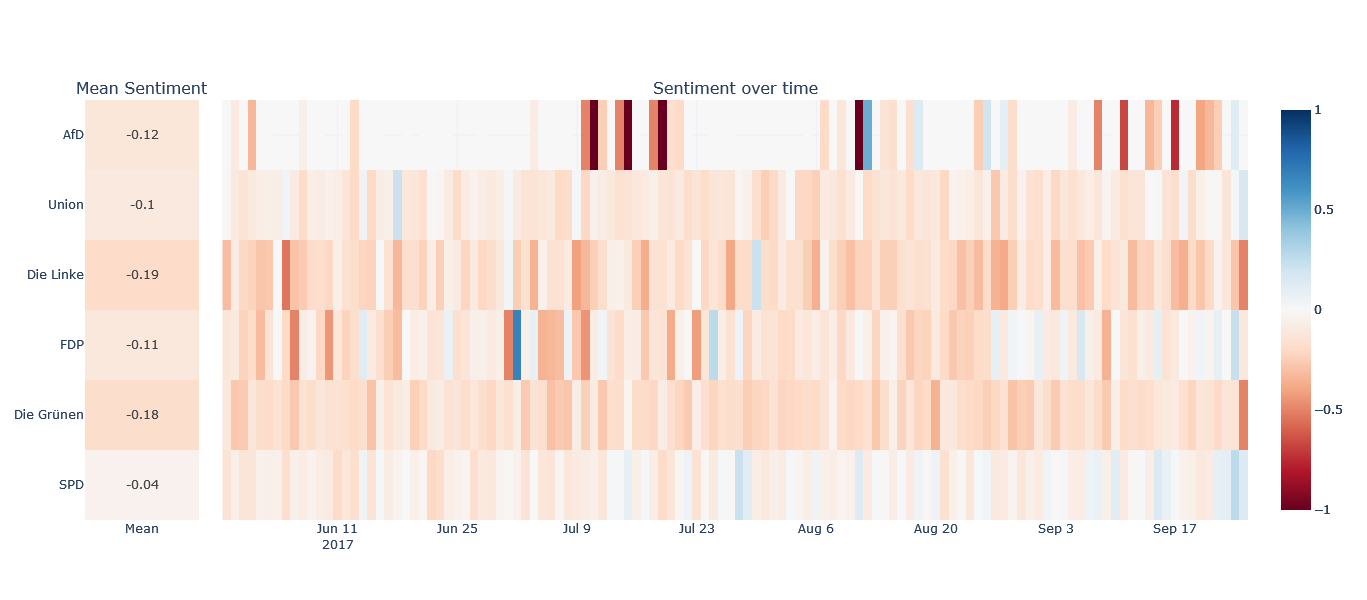

In [15]:
sort_party = {'AfD': 0, 'Union': 1, 'Die Linke': 2, 'FDP': 3, 'Die Grünen': 4, 'SPD': 5} 

df_plot = tweets.groupby(['date', 'party'], as_index=False).mean('sen_score')
df_plot['round_sen_score'] = round(df_plot['sen_score'] *4)/4
df_plot.rename(columns={'date':'Date', 'party':'Party', 'sen_score': 'Sentiment Score'}, inplace=True)

df_plot.replace(to_replace={'Linke': 'Die Linke', 'Grüne': 'Die Grünen', 'CDU/CSU': 'Union'}, inplace=True)
df_plot.sort_values(by='Party', key=lambda x: x.map(sort_party), inplace=True, ascending=False)

agg_df_plot = df_plot[['Party', 'Sentiment Score']].groupby(['Party'], as_index=False).mean('Sentiment Score')
agg_df_plot.sort_values(by='Party', key=lambda x: x.map(sort_party), inplace=True, ascending=False)

df_plot['Sentiment Score'] = round(df_plot['Sentiment Score'], 2)
agg_df_plot['Sentiment Score'] = round(agg_df_plot['Sentiment Score'], 2)

x = []
for i in range(agg_df_plot['Party'].nunique()):
    x.append('Mean')

figures = [
    go.Figure(data=go.Heatmap(
        z=agg_df_plot['Sentiment Score'],
        x=x,
        y=agg_df_plot['Party'],
        zmax=1,
        zmin=-1,
        colorscale='RdBu',
        text=agg_df_plot['Sentiment Score'],
        texttemplate='%{text}',
        hoverinfo='skip')),
    
    go.Figure(data=go.Heatmap(
        z=df_plot['Sentiment Score'],
        x=df_plot['Date'],
        y=df_plot['Party'],
        zmax=1,
        zmin=-1,
        colorscale='RdBu',
        name='Sentiment over time',
        hovertemplate='<br>Date: %{x}<br>Sentiment Score: %{z}'))
    ]
    
fig = make_subplots(rows=1, cols=2, column_widths=[0.1, 0.9], shared_yaxes=True,
                    subplot_titles=('Mean Sentiment', 'Sentiment over time'),
                    horizontal_spacing=0.02)
for i, figure in enumerate(figures):
    for trace in range(len(figure['data'])):
        fig.append_trace(figure['data'][trace], row=1, col=i+1)

rdbu_colors, _ = plotly.colors.convert_colors_to_same_type(plotly.colors.sequential.RdBu)
colorscale = plotly.colors.make_colorscale(rdbu_colors)

fig.update_layout(template='plotly_white', width=1200, height=600,
                  plot_bgcolor=get_continuous_color(colorscale, intermed=0.5),
                  coloraxis=dict(colorscale='RdBu'), showlegend=False, hovermode='y unified')
fig.show()